<a href="https://colab.research.google.com/github/UdaraChamidu/Generative-AI/blob/main/evaluate_rag_application_ragas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Evaluate RAG Application** with RAGAS

In [1]:
# Install the necessary packages
!pip install ragas==0.1.0 -q  # use for evaluate
!pip install langchain==0.3.2 -q
!pip install langchain-chroma -q
!pip install langchain-openai -q
!pip install langchain-community -q
!pip install datasets==2.16.1 -q
!pip install pypdf -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.3.21 requires langchain<1.0.0,>=0.3.23, but you have langchain 0.3.2 which is incompatible.


In [2]:
import os
from google.colab import userdata

import warnings
warnings.filterwarnings('ignore')

### Initialize OpenAI LLM

In [3]:
from langchain_openai import ChatOpenAI

# Set OpenAI API key
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

# Initialize the ChatOpenAI model
llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0
)

### Initialize Embedding Model

In [4]:
from langchain_openai import OpenAIEmbeddings
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

### Load PDF Document

In [5]:
from langchain_community.document_loaders import PyPDFLoader

# Load the PDF document
loader = PyPDFLoader("codeprolk.pdf")

docs = loader.load()

In [6]:
len(docs)

4

### Split Documents into Chunks

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=40)

# Split the documents into chunks
splits = text_splitter.split_documents(docs)

In [8]:
len(splits)

27

### Create Vector Store and Retriever

In [9]:
from langchain_chroma import Chroma

# Create a vector store from the document chunks
vectorstore = Chroma.from_documents(documents=splits, embedding=embedding_model)

In [10]:
# Create a retriever from the vector store
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})

### Define Prompt Template

In [11]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

# Define a message template for the chatbot
message = """
Answer this question using the provided context only.

{question}

Context:
{context}
"""

# Create a chat prompt template from the message
prompt = ChatPromptTemplate.from_messages([("human", message)])

### Create Retrieval-Augmented Generation (RAG) Chain

In [12]:
from langchain.schema.output_parser import StrOutputParser

chain = (
    {"context": retriever,  "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

### Invoke RAG Chain with Example Questions

In [13]:
response = chain.invoke("who is codeprolk")

print(response)

CodePRO LK is a dynamic educational platform founded by Dinesh Piyasamara that offers technology-related courses in Sinhala, aimed at empowering Sri Lankans with valuable skills in programming, data science, and machine learning.


### Evaluate RAG Application

In [14]:
!pip install -q numpy==1.26.4 pandas==2.2.2
import pandas as pd
test_data = pd.read_csv("test_data.csv") # questions and real answers
test_data

,question,answer
0,what is codeprolk,CodePRO LK is a dynamic educational platform ...
1,what is the main vision of them,To assist talented Sri Lankans in reaching th...
2,what is the mission of codeprolk,To produce high-quality tech courses and arti...
3,What are the courses they offer,CodeProLK offers courses like Python GUI with...
4,These courses are for which nationality,CodeProLK's courses are designed specifically...
5,what are the popular videos in codeprolk youtu...,It features popular videos like Python Basics...


In [15]:
questions = test_data["question"].to_list()  # take Q and A to 2 variables
ground_truth = test_data["answer"].to_list()

In [16]:
questions

['what is codeprolk',
 'what is the main vision of them',
 'what is the mission of codeprolk',
 'What are the courses they offer',
 'These courses are for which nationality',
 'what are the popular videos in codeprolk youtube channel']

In [17]:
data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}
# dictionary

In [18]:
for query in questions:
    data["question"].append(query)
    data["answer"].append(chain.invoke(query))
    data["contexts"].append([doc.page_content for doc in retriever.get_relevant_documents(query)])

# add everything to above dictionary

<ipython-input-18-8d5382740057>:4: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  data["contexts"].append([doc.page_content for doc in retriever.get_relevant_documents(query)])


In [19]:
from datasets import Dataset

dataset = Dataset.from_dict(data)

# create dataset object using the dictionary

In [20]:
dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 6
})

In [21]:
dataset[2]

{'question': 'what is the mission of codeprolk',
 'answer': 'The mission of CodePRO LK is to offer a diverse range of technology-related courses in Sinhala, empowering Sri Lankans with valuable skills in programming, data science, and machine learning.',
 'contexts': ['Introduction to CodePRO LK \nCodePRO LK is a dynamic educational platform that offers a diverse range of technology-\nrelated courses in Sinhala, aimed at empowering Sri Lankans with valuable skills in \nprogramming, data science, and machine learning. Founded by Dinesh Piyasamara during the',
  'COVID-19 pandemic, CodePRO LK addresses the growing need for accessible, high-quality \ntech education tailored to the local community. \n \nFounding and Vision \nOrigin and Motivation \nThe inception of CodePRO LK was driven by the challenges posed by the COVID-19 pandemic,'],
 'ground_truth': ' To produce high-quality tech courses and articles that enhance the knowledge base of both students and professionals in the local comm

In [22]:
from ragas.metrics import context_precision, context_recall, answer_relevancy, faithfulness
from ragas import evaluate

result = evaluate(
    dataset = dataset, # the dataset we meda above
    metrics=[
        context_precision,
        context_recall,
        answer_relevancy,
        faithfulness,
    ],
)

/usr/local/lib/python3.11/dist-packages/ragas/metrics/_answer_correctness.py:10: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from ragas.llms.prompt import Prompt


Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

In [23]:
result

{'context_precision': 0.6667, 'context_recall': 1.0000, 'answer_relevancy': 0.8746, 'faithfulness': 1.0000}

In [24]:
results = result.to_pandas()
results

# see the results in a proper way

,question,answer,contexts,ground_truth,context_precision,context_recall,answer_relevancy,faithfulness
0,what is codeprolk,CodePRO LK is a dynamic educational platform t...,[Introduction to CodePRO LK \nCodePRO LK is a ...,CodePRO LK is a dynamic educational platform ...,1.0,1.0,0.854456,1.0
1,what is the main vision of them,The main vision of them is to assist talented ...,[Vision and Mission \n• Vision: To assist tale...,To assist talented Sri Lankans in reaching th...,1.0,1.0,0.850464,1.0
2,what is the mission of codeprolk,The mission of CodePRO LK is to offer a divers...,[Introduction to CodePRO LK \nCodePRO LK is a ...,To produce high-quality tech courses and arti...,1.0,1.0,0.925634,1.0
3,What are the courses they offer,The courses they offer are meticulously struct...,[Learning Experience \nCourse Structure \nEach...,CodeProLK offers courses like Python GUI with...,0.0,1.0,0.823821,1.0
4,These courses are for which nationality,These courses are for individuals of Sinhala n...,[base of both students and professionals in th...,CodeProLK's courses are designed specifically...,1.0,1.0,0.858563,NaN
5,what are the popular videos in codeprolk youtu...,The popular videos on the CodePRO LK YouTube c...,[learning support. \n \nCodePRO LK YouTube Cha...,It features popular videos like Python Basics...,0.0,1.0,0.934523,1.0


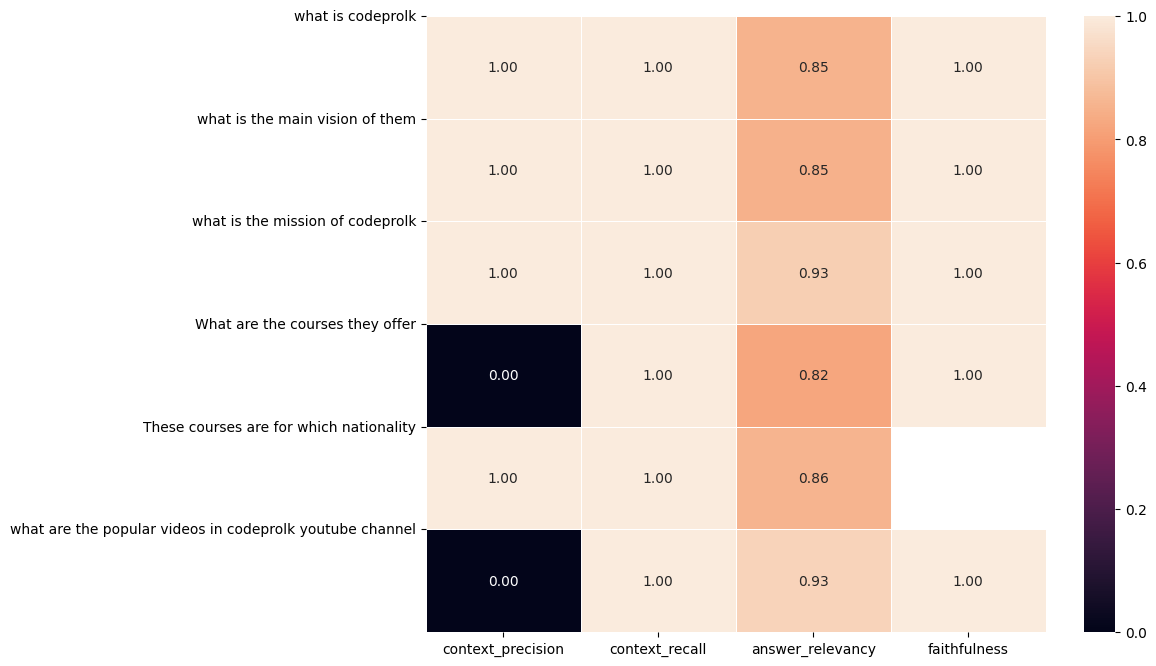

In [25]:
# visualize the above result

import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = results[['context_precision', 'context_recall', 'answer_relevancy', 'faithfulness']]

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5)

plt.yticks(ticks=range(len(results['question'])), labels=results['question'], rotation=0)

plt.show()